### Importando as bibliotecas e definindo algumas classes/funções que serão utilizadas

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def MyNullTreatment(dataframe):
    actions_performed = {}
    for col in dataframe.columns:
        if dataframe[col].isnull().sum() > 0:
            if dataframe[col].isnull().sum() > dataframe.shape[0]*0.8:
                actions_performed[col] = {
                    'type':dataframe[col].dtype,
                    'null_count':dataframe[col].isnull().sum(),
                    'dropped':True,
                    'fill_mean':'','fill_mode':''
                }
                dataframe = dataframe.drop(columns=[col])  
            else:
                if dataframe[col].dtype in ('int64','float64'):
                    actions_performed[col]={
                        'type':dataframe[col].dtype,
                        'null_count':dataframe[col].isnull().sum(),
                        'dropped':False,
                        'fill_mean':dataframe[col].mean(),'fill_mode':''
                        }
                    dataframe[col] = dataframe[col].fillna(dataframe[col].mean())      
                else:
                    actions_performed[col]={
                        'type':dataframe[col].dtype,
                        'null_count':dataframe[col].isnull().sum(),
                        'dropped':False,
                        'fill_mean':'','fill_mode':dataframe[col].mode()[0]}
                    dataframe[col] = dataframe[col].fillna(dataframe[col].mode()[0])
    return dataframe, actions_performed

class MyLabelEncoder:
    def __init__(self, label_list):
        self.label_list = label_list
        self.column = {}
    
    def fit_and_transform(self,dataframe):
        self.train_dataframe = dataframe
        try:
            for col in self.label_list:
                self.column[col] = LabelEncoder()
                dataframe[col] =  self.column[col].fit_transform(dataframe[col])
            return dataframe
        except Exception as e:
            print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
    
    def transform(self,dataframe):
        for col in self.column.keys():
            try:
                dataframe[col] = self.column[col].transform(dataframe[col])
            except Exception as e:
                print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
                print('Proceeding to another fit-transform with train & test dataframe')
                try:
                    self.column[col].fit_transform( pd.concat([self.train_dataframe, dataframe],axis=0) )
                except Exception as e:
                    print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))

        return dataframe
    
class MyOneHotEncoder:
    def __init__(self, column_list):
        self.ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown = 'ignore'), column_list)], remainder='passthrough')
        
    def fit_and_transform(self,dataframe):
        return self.ct.fit_transform(dataframe)
    
    def transform(self,dataframe):
        return self.ct.transform(dataframe)

    
class MyScaler:
    def __init__(self, scaler_list):
        self.scaler_list = scaler_list
        self.column={}
        
    def fit_and_transform(self,dataframe):
        try:
            for col in self.scaler_list:
                self.column[col] = StandardScaler()
                dataframe[col] = pd.DataFrame(self.column[col].fit_transform((dataframe[col].to_numpy()).reshape(-1,1)))[0] 
            return dataframe
        except Exception as e:
            print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
    
    def transform(self,dataframe):
        try:
            for col in self.scaler_list:
                if (col != 'SalePrice') | ('SalePrice' in dataframe.columns):
                    dataframe[col] = pd.DataFrame(self.column[col].transform((dataframe[col].to_numpy()).reshape(-1,1)))[0]
            return dataframe
        except Exception as e:
            print('Class: {}\nColumn: {}\nException: {}'.format(self.__class__.__name__,col,e))
    
    def inverse_transform(self, dataframe, column_name):
        return self.column[column_name].inverse_transform(dataframe)
    
    
def Calculate_Predictions(trained_models):
    results = {}
    for model_name in trained_models:
        results[model_name] = {}

        if model_name == 'Polynomial':
            y_pred = trained_models[model_name][1].predict(trained_models[model_name][0].fit_transform(x_test))    
        else:
            y_pred = trained_models[model_name].predict(x_test)

        y_pred = myScalerEncoder.column['SalePrice'].inverse_transform(y_pred,'SalePrice')
        results[model_name]['y_pred'] = y_pred

        compare = pd.DataFrame(np.concatenate([y_test.reshape(-1,1), y_pred.reshape(-1,1)],axis=1), columns=['y_test','y_pred'])
        compare['dif'] = compare['y_pred']/compare['y_test']
        compare['rmse'] = mean_squared_error(y_test,y_pred, squared=False)
        results[model_name]['compare'] = compare
        print('{}\n{}\n\n'.format(model_name,compare.describe().loc[['mean','std']]))
    
    return results

### Aqui importamos a nossa base de treino, já eliminamos algumas colunas baseado em uma análise manual prévia junto ao entendimento de cada coluna. Em seguida visualizamos como está a dispersão dos valores nulos.

<AxesSubplot:>

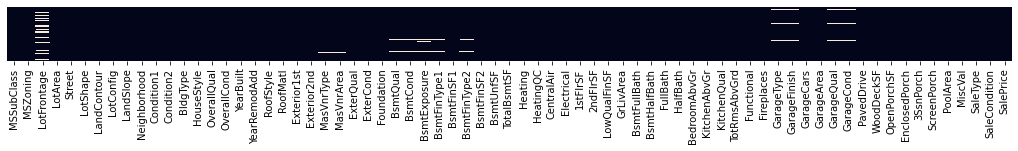

In [2]:
mydata_df = pd.read_csv('train.csv').drop(columns=['Id','Utilities','Alley','Fence','MiscFeature','GarageYrBlt','MoSold','YrSold','FireplaceQu','PoolQC'])
fig, ax = plt.subplots(figsize=(18,1))
sns.heatmap(mydata_df.isnull(),ax=ax,yticklabels=False, cbar=False)

### Abaixo fazemos o tratamento dos valores nulos e mostramos a dispersão dos dados novamente.

,LotFrontage,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageFinish,GarageQual,GarageCond
type,float64,object,float64,object,object,object,object,object,object,object,object,object,object
null_count,259,8,8,37,37,38,37,38,1,81,81,81,81
dropped,False,False,False,False,False,False,False,False,False,False,False,False,False
fill_mean,70.05,,103.685,,,,,,,,,,
fill_mode,,None,,TA,TA,No,Unf,Unf,SBrkr,Attchd,Unf,TA,TA


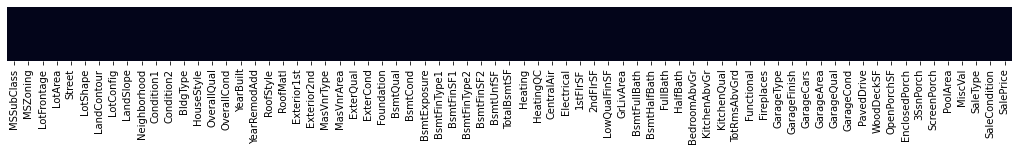

In [3]:
mydata_df, result = MyNullTreatment(mydata_df)
fig, ax = plt.subplots(figsize=(18,1))
sns.heatmap(mydata_df.isnull(),ax=ax,yticklabels=False, cbar=False)
display(pd.DataFrame(result))

### Aqui fazemos o tratamento dos dados e a separação do conjunto de treino(80%) e teste(20%)

In [4]:
label_list, scaler_list, onehot_list = [],[],['MSSubClass','MSZoning','BldgType','HouseStyle']

for col in mydata_df.columns:
    if (mydata_df[col].dtype in ('int64','float64')) & (col not in onehot_list):
        scaler_list.append(col)
    else:
        #onehot_list.append(col)
        if col not in onehot_list:
            label_list.append(col)

try:
    myLabelEncoder = MyLabelEncoder(label_list)
    mydata_df = myLabelEncoder.fit_and_transform(mydata_df)

    myScalerEncoder =  MyScaler(scaler_list)
    mydata_df = myScalerEncoder.fit_and_transform(mydata_df)
    
    x,y = mydata_df.iloc[:,:-1], mydata_df.iloc[:,-1]
    
    myOneHotEncoder = MyOneHotEncoder(onehot_list)
    x = myOneHotEncoder.fit_and_transform(x)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
    y_test = myScalerEncoder.column['SalePrice'].inverse_transform(y_test,'SalePrice')
    
except Exception as e:
    print(e)

### Em seguida criamos um dicionário dos modelos treinados e chamamos uma função para realizar as predições e mostrar os resultados de maneira resumida

In [5]:
trained_models = {}

#trained_models['MultipleLinear'] = LinearRegression()
#trained_models['MultipleLinear'].fit(x_train, y_train)

trained_models['SVR'] = SVR(kernel = 'rbf')
trained_models['SVR'].fit(x_train, y_train)

#trained_models['DecisionTree'] = DecisionTreeRegressor(random_state = 0)
#trained_models['DecisionTree'].fit(x_train,y_train)

trained_models['RandomForest'] = RandomForestRegressor(n_estimators = 271, random_state = 0)
trained_models['RandomForest'].fit(x_train,y_train)

trained_models['XGBoost'] = xgboost.XGBRegressor()
trained_models['XGBoost'].fit(x_train,y_train)

trained_models['MLPRegressor'] = MLPRegressor()
trained_models['MLPRegressor'].fit(x_train,y_train)

prediction_results = Calculate_Predictions(trained_models)
   

/home/bodhi/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


SVR
             y_test         y_pred       dif          rmse
mean  181370.383562  178882.324054  1.010616  36128.561064
std    83244.107342   68620.438980  0.169278      0.000000


RandomForest
             y_test         y_pred       dif          rmse
mean  181370.383562  181493.773568  1.022087  30970.686665
std    83244.107342   74006.140603  0.168325      0.000000


XGBoost
             y_test         y_pred       dif          rmse
mean  181370.383562  181267.104907  1.012591  2.850473e+04
std    83244.107342   77212.642904  0.159880  7.288449e-12


MLPRegressor
             y_test         y_pred       dif          rmse
mean  181370.383562  181877.153060  1.009936  41637.337898
std    83244.107342   86848.950475  0.258430      0.000000




#### A coluna 'dif' dos modelos acima, é uma divisão entre o y_test/y_pred ... ou seja, quanto mais a média(mean) for próxima de 1, mais acertivo foi o nosso modelo ... e quanto menor o valor do desvio padrão(std), menor é a dispersão dos dados quanto ao valor previsto.
#### Levando isso em conta temos então que os 2 melhores modelos são o SVR e o XGBoost, onde este segundo vence apenas por uma menor dispersão enquanto o primeiro por uma melhor acertividade.

#### Para conferir e explorar os valores previstos com cada modelo, basta utilizar o dicionário 'prediction_results'.
#### Este dicionario contém 'y_pred' de cada modelo e uma tabela comparativa
Ex.: prediction_results['SVR']['compare']

#### Segue abaixo uma tabela com os valores previstos de cada modelo

In [6]:
model_results = pd.concat([ pd.DataFrame(prediction_results[model_name]['y_pred'], columns=[model_name]) for model_name in prediction_results], axis=1)
model_results = pd.concat([pd.DataFrame(y_test, columns=['Y_Test']),model_results],axis=1)
model_results

,Y_Test,SVR,RandomForest,XGBoost,MLPRegressor
0,200624.0,222395.827137,215571.309963,228482.546875,204408.405207
1,133000.0,156750.679912,145909.730627,153587.625000,164561.809865
2,110000.0,130184.225762,105728.357934,95236.953125,97237.769585
3,192000.0,217556.930444,219747.018450,195817.937500,188416.566065
4,88000.0,100211.473906,92430.247232,87457.789062,96962.116364
...,...,...,...,...,...
287,324000.0,257225.915634,295606.774908,302955.656250,355125.681056
288,555000.0,401251.814278,449122.811808,518437.062500,485222.805163
289,136000.0,168173.759810,156520.830258,157280.484375,194611.658517
290,82500.0,102211.896010,82946.140221,70856.585938,100894.699499


#### Adotaremos o SVR como o melhor modelo e criaremos o arquivo "sample_submission.csv" para enviar ao Kaagle

In [8]:
submission_data = pd.read_csv('test.csv')
subdata_df = submission_data.copy()
subdata_df = subdata_df.drop(columns=['Id','Utilities','Alley','Fence','MiscFeature','GarageYrBlt','MoSold','YrSold','FireplaceQu','PoolQC'])
subdata_df, result = MyNullTreatment(subdata_df)

try:
    subdata_df = myLabelEncoder.transform(subdata_df)
    subdata_df = myScalerEncoder.transform(subdata_df)
    subdata_df = myOneHotEncoder.transform(subdata_df) 
except Exception as e:
    print(e)

y_subm = trained_models['XGBoost'].predict(subdata_df)
y_subm = myScalerEncoder.column['SalePrice'].inverse_transform(y_subm,'SalePrice')
sample_submission = pd.DataFrame(y_subm, columns=['SalePrice'], index=submission_data['Id'].array)
sample_submission.to_csv('sample_submission.csv',index_label='Id')
